# Space Images Classifier - Using Kaggle dataset

https://www.kaggle.com/datasets/abhikalpsrivastava15/space-images-category?utm_source=chatgpt.com

### This notebook aims for data exploratory

# Import librairies

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os
# Add the root folder to Python's module search path
sys.path.append(os.path.abspath(os.path.join(".."))) 
# Import the project configuration
from config import DEVICE, ORIGINAL_DATA_PATH, OUTPUT_PATH, SEED, TRAIN_RATIO, VAL_RATIO, TEST_RATIO

from pathlib import Path
import cv2
from tqdm import tqdm
import torch
import random

import warnings
warnings.filterwarnings('ignore')

# Settings to optimize M1 Chip

In [3]:
# ============================================================================
# Configuration optimized for M1 Chip
# ============================================================================
print("=" * 80)
print("Optimized parameters for M1 Chip")
print("-" * 80)

print(f"Device: {DEVICE}")

print("=" * 80)

Optimized parameters for M1 Chip
--------------------------------------------------------------------------------
Device: mps


# Data configuration

In [4]:
print("=" * 80)

random.seed(SEED)
np.random.seed(SEED)
import torch
torch.manual_seed(SEED)
if DEVICE.type == "mps":
    torch.mps.manual_seed(SEED)

print(f"Original dataset: {ORIGINAL_DATA_PATH}")
print(f"Split dataset: {OUTPUT_PATH}")
print(f"Split ratios: Train={TRAIN_RATIO}, Val={VAL_RATIO}, Test={TEST_RATIO}")
print(f"Random seed: {SEED} (for reproducibility)")
print("=" * 80)

Original dataset: ../space-images-category
Split dataset: ../space_images_split
Split ratios: Train=0.7, Val=0.15, Test=0.15
Random seed: 42 (for reproducibility)


# Data Exploratory Analysis

## 1. Dataset structure and statistics

In [5]:
# List all subfolders which each represents a class
classes = sorted([d.name for d in ORIGINAL_DATA_PATH.iterdir() if d.is_dir()])
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

# Count images per class
class_counts = {cls: len(list((ORIGINAL_DATA_PATH / cls).glob("*.jpg"))) for cls in classes}
df_counts = pd.DataFrame.from_dict(class_counts, orient='index', columns=['count']).reset_index()
df_counts.columns = ['class', 'count']

df_counts.head()

Number of classes: 6
Classes: ['constellation', 'cosmos space', 'galaxies', 'nebula', 'planets', 'stars']


,class,count
0,constellation,183
1,cosmos space,166
2,galaxies,237
3,nebula,170
4,planets,176


## Visualize class distribution

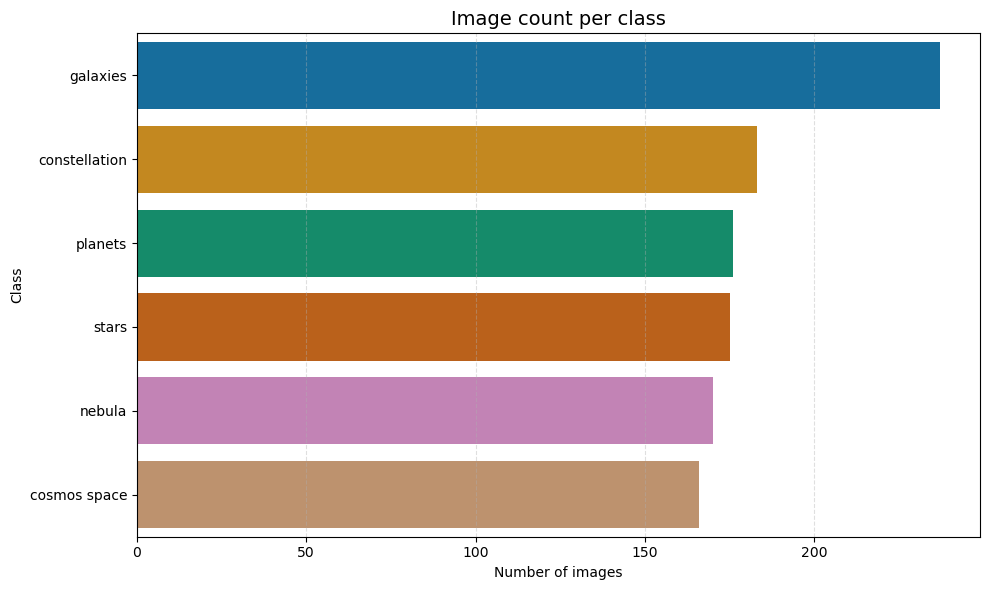

In [6]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_counts.sort_values("count", ascending=False),
    x="count", y="class", palette='colorblind'
)
plt.title("Image count per class", fontsize=14)
plt.xlabel("Number of images")
plt.ylabel("Class")
plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

## Display sample image from each class

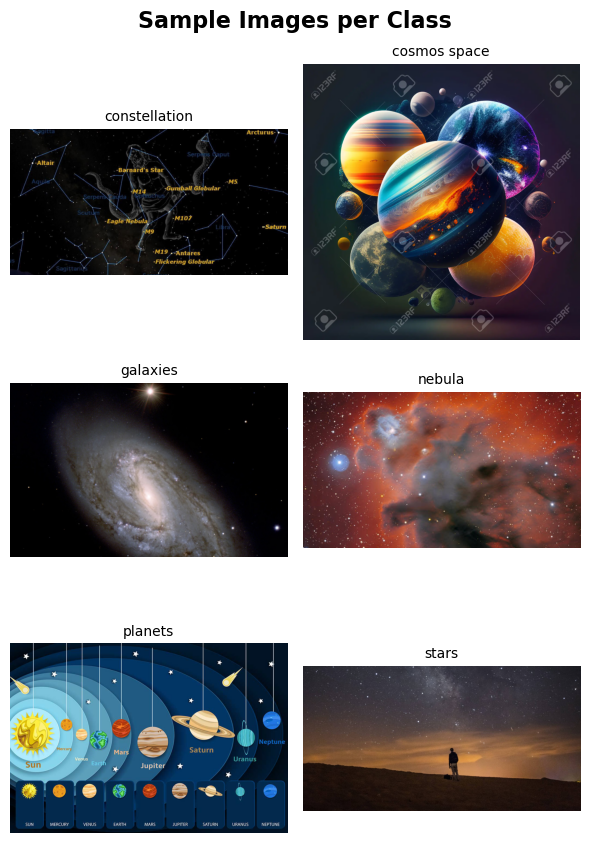

In [7]:
def show_sample_images(data_path, classes, n_per_row=2):
    n_classes = len(classes)
    n_rows = int(np.ceil(n_classes / n_per_row))
    plt.figure(figsize=(n_per_row * 3, n_rows * 3))
    
    for idx, cls in enumerate(classes):
        img_files = list((data_path / cls).glob("*.jpg"))
        if len(img_files) == 0:
            continue
        img_path = np.random.choice(img_files)
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        plt.subplot(n_rows, n_per_row, idx + 1)
        plt.imshow(img)
        plt.title(cls, fontsize=10)
        plt.axis("off")
    
    plt.suptitle("Sample Images per Class", fontsize=16, weight='bold')
    plt.tight_layout()
    plt.show()

show_sample_images(ORIGINAL_DATA_PATH, classes[:10])


## Image property statistics - For resizing strategy

In [8]:
image_shapes = []

for cls in tqdm(classes, desc="Reading image shapes"):
    for img_path in (ORIGINAL_DATA_PATH / cls).glob("*.jpg"):
        img = cv2.imread(str(img_path))
        if img is not None:
            h, w = img.shape[:2]
            # aspect_ratio to know if it's landscape, portrait or square-like image
            image_shapes.append({"class": cls, "width": w, "height": h, "aspect_ratio": w / h})

df_shapes = pd.DataFrame(image_shapes)
df_shapes.describe()

Reading image shapes:  33%|███▎      | 2/6 [00:05<00:11,  2.80s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Reading image shapes:  83%|████████▎ | 5/6 [00:15<00:03,  3.14s/it]libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
Reading image shapes: 100%|██████████| 6/6 [00:18<00:00,  3.13s/it]


,width,height,aspect_ratio
count,1097.000000,1097.000000,1097.000000
mean,1316.441203,930.410210,1.495176
std,932.474706,689.463234,0.390365
min,220.000000,146.000000,0.462203
25%,750.000000,500.000000,1.250211
50%,1153.000000,720.000000,1.500375
75%,1500.000000,1080.000000,1.777778
max,8000.000000,5834.000000,3.567398


## Image size distribution

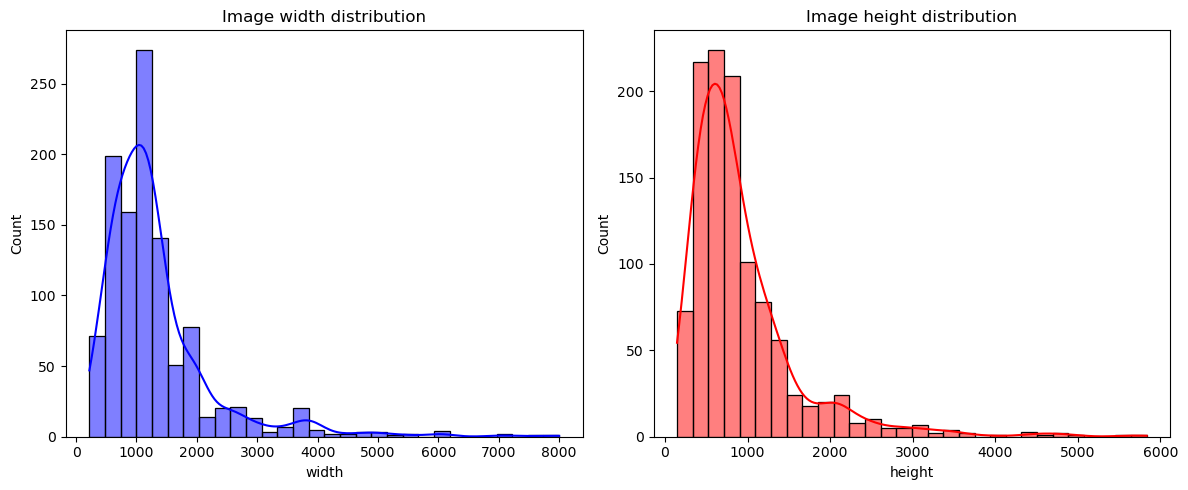

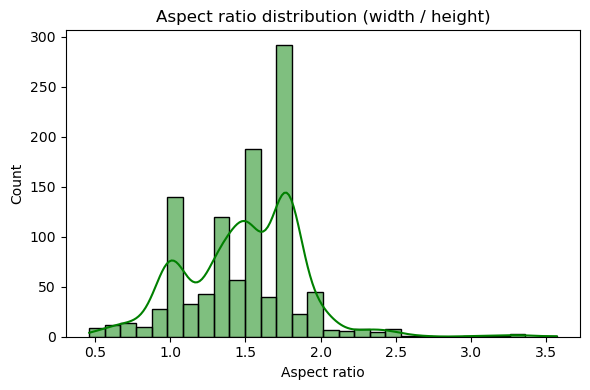

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_shapes["width"], bins=30, kde=True, color="blue")
plt.title("Image width distribution")

plt.subplot(1, 2, 2)
sns.histplot(df_shapes["height"], bins=30, kde=True, color="red")
plt.title("Image height distribution")

plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df_shapes["aspect_ratio"], bins=30, kde=True, color="green")
plt.title("Aspect ratio distribution (width / height)")
plt.xlabel("Aspect ratio")
plt.tight_layout()
plt.show()


# End of notebook 1 - Data exploratory.